# Dosa / No Dosa - Transfer Learning

## Frame the Problem

We want to classify the images in two categories - **Dosa** and **No-Dosa**. This is a classical two-class image classification problem.
- Dosa
- No-Dosa

## Acquire the Data

These images very downloaded google.com/images with "reuse with modification" filter to allow for commercial reuse.

In [1]:
#!mkdir data
#!wget https://bit.do/dosa-nodosa -O data/food-binary.zip
#!cd data && unzip food-binary.zip

### Load basic libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

Using TensorFlow backend.


## Transfer Learning with Image Augementation

**Step 1: Prepare the images and labels**

In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
data = ImageDataGenerator(validation_split=0.2, 
                          rescale=1/255,
                          samplewise_center=False, # set input mean to 0 over the sample
                          samplewise_std_normalization=False,  # divide inputs by std of the sample
                          rotation_range=90,       # randomly rotate images in the range (degrees, 0 to 180)
                          width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
                          height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                          fill_mode='reflect',     # filling the area outside
                          zoom_range=0.4,          # random zoom
                          horizontal_flip=True,    # randomly flip images
                          vertical_flip=True)      # randomly flip images

In [4]:
train_generator = data.flow_from_directory(directory="data/food-binary/", 
                                           target_size=(224,224),
                                           class_mode="categorical", 
                                           shuffle=True, 
                                           batch_size=8, 
                                           subset='training')

Found 260 images belonging to 2 classes.


In [5]:
val_generator = data.flow_from_directory(directory="data/food-binary/", 
                                           target_size=(224,224),
                                           class_mode="categorical", 
                                           shuffle=True, 
                                           batch_size=8, 
                                           subset='validation')

Found 65 images belonging to 2 classes.


**Step 2: Using a Transfer Learning Model **

Let us load the ResNet50 model without the classifier layer and **do not** train the weights

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, GlobalAveragePooling2D

In [7]:
conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling="avg")

In [8]:
for layer in conv_base.layers:
    layer.trainable = False

In [9]:
x = conv_base.output
x = Dense(512, activation='relu')(x) # let's add a fully-connected layer
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x) # let's add a fully-connected layer
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
m = Model(inputs=conv_base.input, outputs=predictions)

In [10]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [12]:
m.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [ ]:
m_output =  m.fit_generator(train_generator, epochs=8, steps_per_epoch=1000 // 8,
                            validation_data=val_generator, validation_steps=600 // 8,
                            verbose = 1)

Epoch 1/8
125/125 [==============================] - 33s 261ms/step - loss: 0.5498 - acc: 0.7380 - val_loss: 0.7019 - val_acc: 0.3309
Epoch 2/8
125/125 [==============================] - 31s 246ms/step - loss: 0.3690 - acc: 0.8480 - val_loss: 0.7806 - val_acc: 0.3217
Epoch 3/8
125/125 [==============================] - 32s 254ms/step - loss: 0.3469 - acc: 0.8640 - val_loss: 0.7919 - val_acc: 0.3180
Epoch 4/8
125/125 [==============================] - 30s 241ms/step - loss: 0.3159 - acc: 0.8740 - val_loss: 0.8040 - val_acc: 0.3254
Epoch 5/8
125/125 [==============================] - 30s 241ms/step - loss: 0.2543 - acc: 0.8920 - val_loss: 1.0224 - val_acc: 0.3272
Epoch 6/8
117/125 [===========================>..] - ETA: 1s - loss: 0.2511 - acc: 0.8793

In [20]:
m_metrics = m_output.history

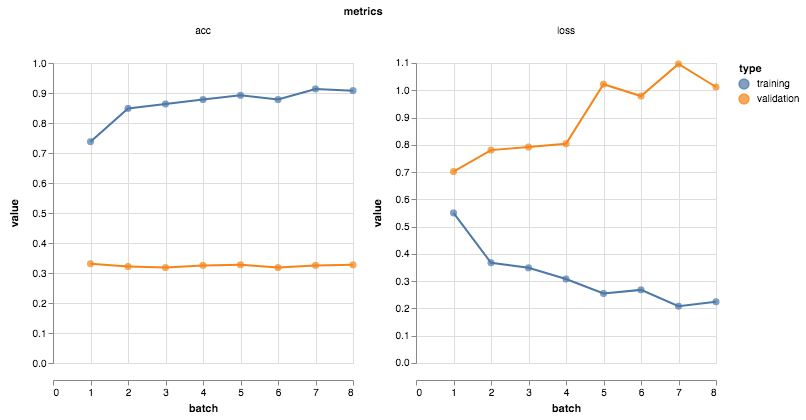

In [21]:
vis.metrics(m_metrics)

## Fine Tuning a Transfer Learning Model

Retrain the last 3 layers of base model with image augmentation

In [ ]:
for layer in m.layers[:47]:
   layer.trainable = False
for layer in m.layers[47:]:
   layer.trainable = True

In [ ]:
m.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [18]:
m_output_trainable =  m.fit_generator(train_generator, epochs=8, steps_per_epoch=1000 // 8,
                            validation_data=val_generator, validation_steps=600 // 8,
                            verbose = 1)

125/125 [==============================] - 50s 399ms/step - loss: 0.1902 - acc: 0.9300 - val_loss: 0.6312 - val_acc: 0.6820
Epoch 2/8
125/125 [==============================] - 42s 335ms/step - loss: 0.1355 - acc: 0.9440 - val_loss: 0.8368 - val_acc: 0.6783
Epoch 3/8
125/125 [==============================] - 42s 337ms/step - loss: 0.0909 - acc: 0.9690 - val_loss: 0.6310 - val_acc: 0.6783
Epoch 4/8
125/125 [==============================] - 42s 337ms/step - loss: 0.0778 - acc: 0.9750 - val_loss: 0.7535 - val_acc: 0.6820
Epoch 5/8
125/125 [==============================] - 42s 335ms/step - loss: 0.0599 - acc: 0.9790 - val_loss: 1.0659 - val_acc: 0.6801
Epoch 6/8
125/125 [==============================] - 41s 332ms/step - loss: 0.0751 - acc: 0.9740 - val_loss: 1.1286 - val_acc: 0.6857
Epoch 7/8
125/125 [==============================] - 42s 334ms/step - loss: 0.0761 - acc: 0.9720 - val_loss: 0.7452 - val_acc: 0.6783
Epoch 8/8
125/125 [==============================] - 42s 338ms/step - lo

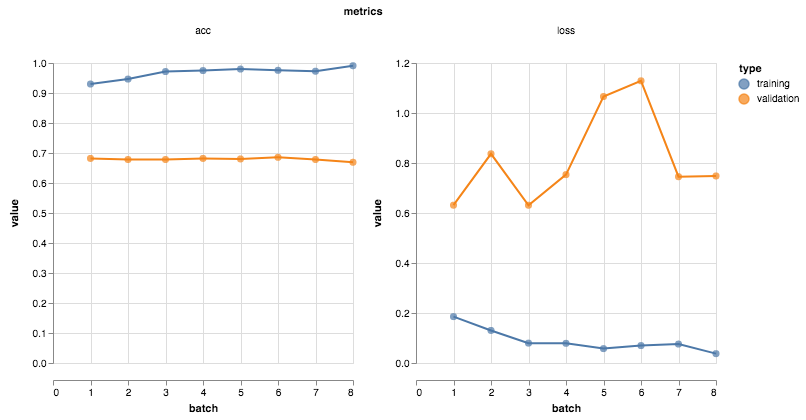

In [19]:
vis.metrics(m_output_trainable.history)